<a href="https://colab.research.google.com/github/ekamperi/colab/blob/master/SVHN_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classifier for the SVHN dataset


[SVHN dataset](http://ufldl.stanford.edu/housenumbers/) is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. Our goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

Reference:
* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.



In [85]:
# Import stuff that we willl need

import math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from random import sample
from scipy.io import loadmat

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
# Load the dataset from our Drive folder

train = loadmat('gdrive/MyDrive/Colab Notebooks/svhn_dataset/train_32x32.mat')
test = loadmat('gdrive/MyDrive/Colab Notebooks/svhn_dataset/test_32x32.mat')

In [8]:
# Take a look at the data shapes

print("Train inputs shape = ", train['X'].shape)
print("Train targets shape = ", train['y'].shape)
print("Test inputs shape = ", test['X'].shape)
print("Test targets shape = ", test['y'].shape)

Train inputs shape =  (32, 32, 3, 73257)
Train targets shape =  (73257, 1)
Test inputs shape =  (32, 32, 3, 26032)
Test targets shape =  (26032, 1)


Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* We will extract the training and testing images and labels separately from the train and test dictionaries.
* We will convert the training and test images to grayscale by taking the average across all colour channels for each pixel. 1._
* We will display some color and grayscale images along with their true labels.

In [10]:
# Split into train/test and input/targets.
# Also rescale input values to [0, 1]
train_inputs, train_targets = train['X']/255., train['y']
test_inputs, test_targets = test['X']/255., test['y']

# The digit "0" has a label "10". Replace it with a label "0".
train_targets = np.where(train_targets < 10, train_targets, 0)
test_targets = np.where(test_targets < 10, test_targets, 0)

# Rearrange axis so that the first image is [1, :, :, :]
# rather than [:, :, :, 1]
train_inputs = np.moveaxis(train_inputs,-1,0)
test_inputs = np.moveaxis(test_inputs,-1,0)

print("Train inputs shape = ", train_inputs.shape)
print("Train targets shape = ", train_targets.shape)
print("Test inputs shape = ", test_inputs.shape)
print("Test targets shape = ", test_targets.shape)

Train inputs shape =  (73257, 32, 32, 3)
Train targets shape =  (73257, 1)
Test inputs shape =  (26032, 32, 32, 3)
Test targets shape =  (26032, 1)


In [69]:
def plot_random_images(input_dataset, target_dataset, howmany=10, cmap=None):
    # Get the total number of examples in the dataset
    len, _, _, _ = input_dataset.shape

    # Generate `howmany` random integers spanning the whole dataset
    randomIndexes = sample(range(0, len), howmany)

    # Set the total figure's size
    plt.figure(figsize=(15,5))

    # Plot the images in a row
    for i in range(howmany):
        plt.subplot(2, math.ceil(howmany/2), i+1)
        idx = randomIndexes[i]
        plt.imshow(input_dataset[idx, :, :, :].squeeze(), cmap=cmap)
        plt.text(1, 0, "Label: " + str(target_dataset[idx, 0]), color="yellow",
                bbox=dict(fill=True, edgecolor='red', linewidth=1))
    plt.show()

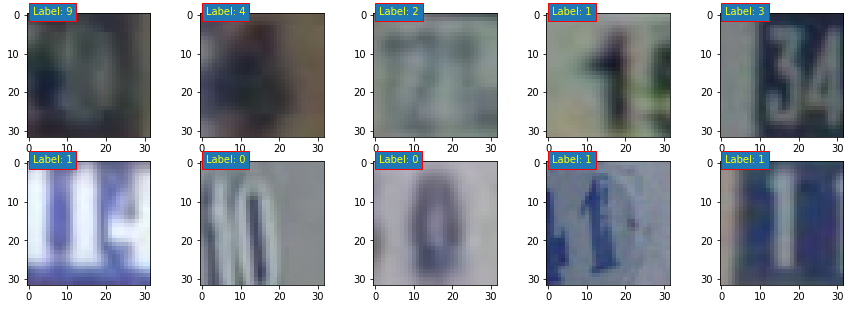

In [71]:
plot_random_images(train_inputs, train_targets, 10)

In [72]:
# Convert the training and test images to grayscale by taking the average across
# all colour channels for each pixel. We will retain the channel dimension, which
# will now have size 1.

# Convert the training set
train_inputs = np.mean(train_inputs, axis=3, keepdims=True)

# Convert the test set
test_inputs = np.mean(test_inputs, axis=3, keepdims=True)

In [73]:
# Print data shapes after the conversion of 3-channel color images to 1-channel
# grayscale images. They should be (?, 32, 32, 1).

print("Train inputs shape = ", train_inputs.shape)
print("Test inputs shape = ", test_inputs.shape)

Train inputs shape =  (73257, 32, 32, 1)
Test inputs shape =  (26032, 32, 32, 1)


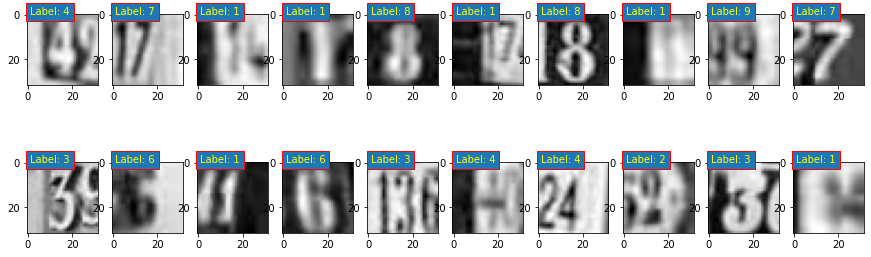

In [83]:
# Plot some images from the gray training set.
plot_random_images(train_inputs, train_targets, 20, cmap='gray')

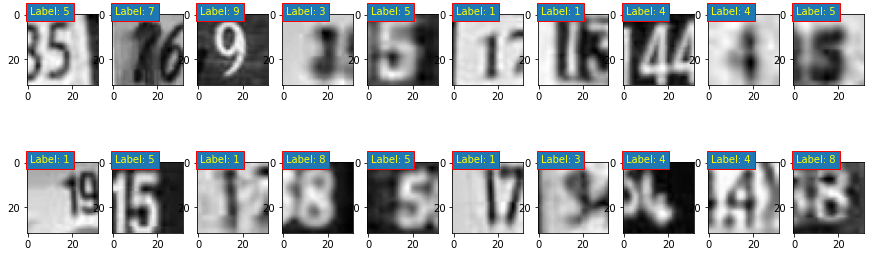

In [84]:
# Plot some images from the gray test set.
plot_random_images(test_inputs, test_targets, 20, cmap="gray")

## 2. MLP neural network classifier
* We will build an MLP classifier model using the Sequential API, with Flatten and Dense layers, only. The final layer will have a 10-way softmax output.


In [86]:
def get_new_mlp_model(input_shape):
    model = Sequential([
                        Flatten(input_shape=input_shape),
                        Dense(256, activation="relu", name="dense_1"),
                        Dense(128, activation="relu", name="dense_2"),
                        Dense(64, activation="relu", name="dense_3"),
                        Dense(10, activation="softmax", name="dense_4")
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [87]:
# Our model tracks at least one appropriate metric, and uses at least two
# callbacks during training, one of which is a ModelCheckpoint callback.

def get_early_stopping():
    """
    This function returns an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last 15 epochs.
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=15,
                                                      monitor="val_accuracy")
    return early_stopping

def get_checkpoint_best_only(checkpoint_path):
    """
    This function returns a ModelCheckpoint object that:
    - saves only the weights that generate the highest validation (testing)
      accuracy
    - saves into a directory supplied in `checkpoint_path` argument inside the
      current working directory
    """
    checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                 save_freq='epoch',
                                 save_weights_only=True,
                                 monitor='val_accuracy',
                                 save_best_only=True)
    return checkpoint 

In [88]:
# We create the callbacks

mlp_checkpoint_path = "mlp_checkpoints_best_only/checkpoint"
mlp_checkpoint_best_only = get_checkpoint_best_only(mlp_checkpoint_path)
early_stopping = get_early_stopping()

In [95]:
# Print out the model summary

mlp_model = get_new_mlp_model(input_shape=train_inputs[0].shape)
mlp_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 304,202
Trainable params: 304,202
Non-trainable params: 0
_________________________________________________________________


In [96]:
# Compile and train the model, making use of both training and validation sets
# during the training run. We should aim to achieve a final categorical cross
# entropy training loss of less than 1.0 (the validation loss might be higher).

mlp_history = mlp_model.fit(train_inputs, train_targets,
                            validation_split=0.15, epochs=30, verbose=1,
                            callbacks=[mlp_checkpoint_best_only,
                                       early_stopping])

In [97]:
# Plot the learning curves for loss vs epoch and accuracy vs epoch for both
# training and validation sets.

def plot_loss(models_history):
    plt.plot(models_history.history["loss"])
    plt.plot(models_history.history["val_loss"])
    plt.title("Loss vs. Epoch")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Training", "Validation"], loc="upper right")
    plt.grid(True)

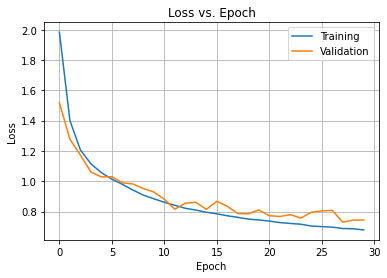

In [98]:
plot_loss(mlp_history)

In [99]:
def plot_accuracy(models_history):
    plt.plot(models_history.history["accuracy"])
    plt.plot(models_history.history["val_accuracy"])
    plt.title("Accuracy vs. Epoch")
    plt.ylabel("Accuraccy")
    plt.xlabel("Epoch")
    plt.legend(["Training", "Validation"], loc="center right")
    plt.grid(True)

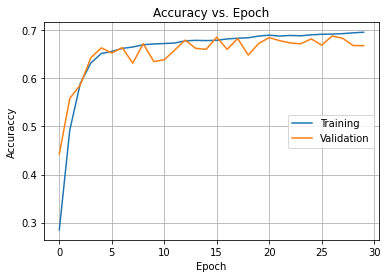

In [ ]:
plot_accuracy(mlp_history)

In [100]:
# Compute and display the loss and accuracy of the trained model on the test set

mlp_model.evaluate(test_inputs, test_targets, verbose=2)

814/814 - 1s - loss: 0.8677 - accuracy: 0.7433


[0.8677465915679932, 0.7432774901390076]

In [101]:
# List the files in the checkpoints_best_only directory

! ls -lh mlp_checkpoints_best_only

total 3.5M
-rw-r--r-- 1 root root   77 Dec  6 00:47 checkpoint
-rw-r--r-- 1 root root 3.5M Dec  6 00:47 checkpoint.data-00000-of-00001
-rw-r--r-- 1 root root 2.0K Dec  6 00:47 checkpoint.index


## 3. CNN neural network classifier
* We will now build a CNN classifier model using the Sequential API. Our model will use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer will have a 10-way softmax output. 

In [103]:
def get_new_cnn_model(input_shape):
    model = Sequential([
                      Conv2D(16, (3,3),
                             activation='relu', padding='SAME',
                             input_shape=input_shape, name="conv_1"),
                      Conv2D(8, (3,3),
                             activation='relu', padding='SAME',
                             name="conv_2"),
                      BatchNormalization(name="batch_1"),
                      MaxPooling2D((8,8), name="pool_1"),
                      Flatten(name="flatten_1"),
                      Dense(128, activation="relu", name="dense_1"),
                      Dropout(0.3, name="dropout_1"),
                      Dense(64, activation="relu", name="dense_2"),
                      Dense(10, activation="softmax", name="dense_3")                      
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [104]:
# Run this to create the callbacks
# The early stopping callback is common between MLP and CNN models

cnn_checkpoint_path = "cnn_checkpoints_best_only/checkpoint"
cnn_checkpoint_best_only = get_checkpoint_best_only(cnn_checkpoint_path)

In [105]:
# Compile and train the model (we recommend a maximum of 30 epochs),
# making use of both training and validation sets during the training run

cnn_model = get_new_cnn_model(input_shape=train_inputs[0].shape)
cnn_model.summary()

# The CNN model should use fewer trainable parameters than your MLP model.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 8)         1160      
_________________________________________________________________
batch_1 (BatchNormalization) (None, 32, 32, 8)         32        
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)              

In [107]:
cnn_history = cnn_model.fit(train_inputs, train_targets,
                            validation_split=0.15, epochs=30, verbose=1,
                    callbacks=[cnn_checkpoint_best_only,
                               early_stopping])

Epoch 1/30
1946/1946 [==============================] - 6s 3ms/step - loss: 1.4751 - accuracy: 0.4998 - val_loss: 1.0733 - val_accuracy: 0.6446
Epoch 2/30
1946/1946 [==============================] - 6s 3ms/step - loss: 1.0256 - accuracy: 0.6645 - val_loss: 0.9521 - val_accuracy: 0.7010
Epoch 3/30
1946/1946 [==============================] - 6s 3ms/step - loss: 0.9443 - accuracy: 0.6930 - val_loss: 0.8393 - val_accuracy: 0.7299
Epoch 4/30
1946/1946 [==============================] - 6s 3ms/step - loss: 0.8920 - accuracy: 0.7107 - val_loss: 0.8489 - val_accuracy: 0.7272
Epoch 5/30
1946/1946 [==============================] - 6s 3ms/step - loss: 0.8550 - accuracy: 0.7244 - val_loss: 0.7990 - val_accuracy: 0.7455
Epoch 6/30
1946/1946 [==============================] - 6s 3ms/step - loss: 0.8294 - accuracy: 0.7319 - val_loss: 0.8433 - val_accuracy: 0.7248
Epoch 7/30
1946/1946 [==============================] - 6s 3ms/step - loss: 0.8096 - accuracy: 0.7376 - val_loss: 0.7884 - val_accuracy:

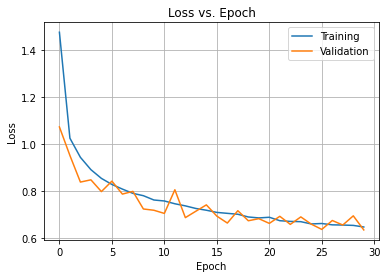

In [108]:
# Plot the learning curves for loss vs epoch and accuracy vs epoch for both
# training and validation sets

plot_loss(cnn_history)

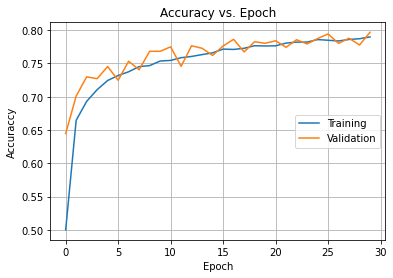

In [109]:
plot_accuracy(cnn_history)

In [110]:
# Compute and display the loss and accuracy of the trained model on the test set
# We beat the MLP model performance with fewer parameters!

cnn_model.evaluate(test_inputs, test_targets, verbose=2)

814/814 - 1s - loss: 0.6673 - accuracy: 0.7881


[0.667291522026062, 0.7880685329437256]

## 4. Get model predictions


In [116]:
# We load the best weights for the MLP and CNN models that we have saved during
# the training run.
input_shape = train_inputs[0].shape

best_mlp_model = get_new_mlp_model(input_shape)
best_mlp_model.load_weights(mlp_checkpoint_path)

best_cnn_model = get_new_cnn_model(input_shape)
best_cnn_model.load_weights(cnn_checkpoint_path)

In [117]:
# We randomly select 5 images and corresponding labels from the test set and
# display the images with their labels.

def get_random_images(input_dataset, target_dataset, num):
    # Get the total number of examples in the dataset
    len, _, _, _ = input_dataset.shape

    # Generate `num` random integers spanning the whole dataset
    randomIdxs = sample(range(0, len), num)

    return (input_dataset[randomIdxs,:,:,:], target_dataset[randomIdxs,0])

In [118]:
def plot_images(fromsample, cmap=None):
    # Set the total figure's size
    plt.figure(figsize=(15,5))

    input_dataset, target_labels = fromsample
    L = len(input_dataset)

    for i in range(L):
        plt.subplot(1,L,i+1)
        plt.imshow(input_dataset[i,:,:,:].squeeze(), cmap=cmap)
        plt.text(0, 0, "Label: " + str(target_labels[i]), color="yellow",
                bbox=dict(fill=True, edgecolor='red', linewidth=1))
    plt.show()

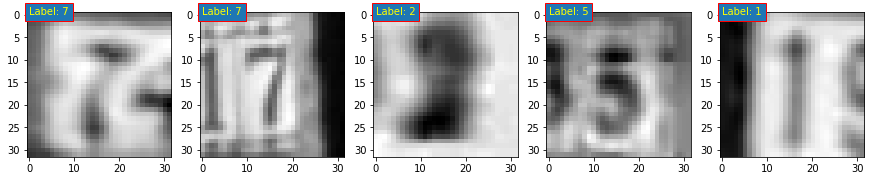

In [119]:
five_sample = get_random_images(test_inputs, test_targets, 5)
plot_images(five_sample, cmap='gray')

In [120]:
# Alongside the image and label, show each model’s predictive distribution as
# a bar chart, and the final model prediction given by the label with maximum
# probability.

def plot_color_bar(data, title):
    L = len(data)
    cols = ['tab:blue'] * L
    labelIdx = np.argmax(data)
    cols[labelIdx] = "tab:red"
    plt.bar(np.arange(L), data, color = cols)
    idx = np.asarray([i for i in range(L)]) # Used for the x ticks
    plt.xticks(idx)
    plt.ylim(0,1)
    plt.title(title)
    plt.text(7.9,0.95, "Label: " + str(labelIdx), color="yellow",
                bbox=dict(fill=True, edgecolor='red', linewidth=1))

def cmp_pred(fromsample, best_mlp, best_cnn):
    L, _, _, _ = fromsample[0].shape
    idx = np.asarray([i for i in range(11)]) # Used for the x ticks

    for i in range(L):
        mlp_pred = best_mlp.predict(fromsample[0][i][np.newaxis])
        cnn_pred = best_cnn.predict(fromsample[0][i][np.newaxis])
        plt.figure(figsize=(15,3))

        # Plot the input image along with the ground truth label
        plt.subplot(1,3,1)
        plt.imshow(fromsample[0][i].squeeze(), cmap = 'gray')
        plt.text(0, 2, "Label: " + str(fromsample[1][i]), color="yellow",
                bbox=dict(fill=True, edgecolor='red', linewidth=1))
        plt.title('Test input image')

        # Plot MLP's predictions
        plt.subplot(1,3,2)
        plot_color_bar(mlp_pred[0], "Best MLP Model")

        # Plot CNN's predictions
        plt.subplot(1,3,3)
        plot_color_bar(cnn_pred[0], "Best CNN Model")

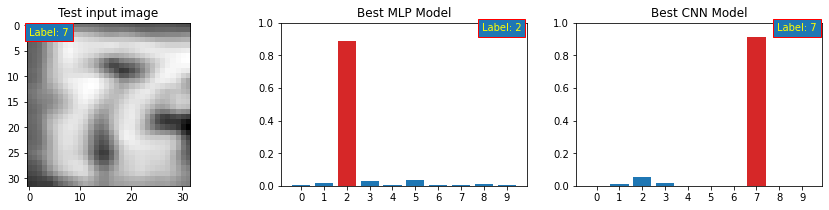

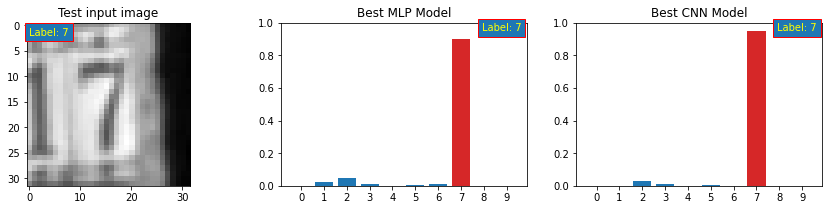

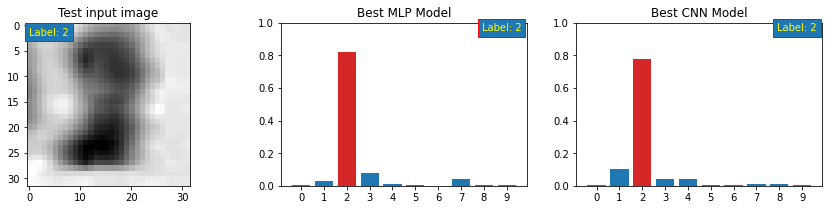

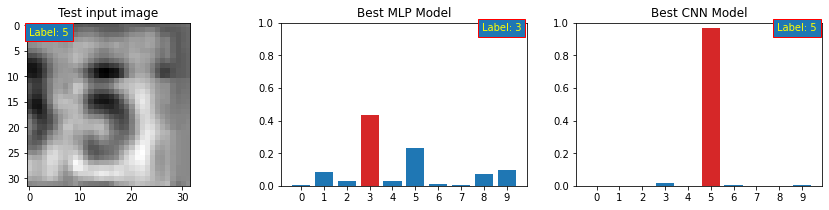

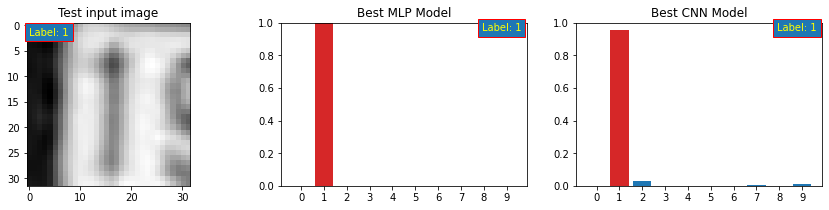

In [121]:
cmp_pred(five_sample,best_mlp_model,best_cnn_model)

In [122]:
# Uncomment to export notebeook as pdf
# !sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended
# !jupyter nbconvert --to PDF "gdrive/MyDrive/Colab Notebooks/Capstone_Project.ipynb"